# Artem Moskalev. Homework 2.2: The Quest For A Better Network

In this assignment you will:

    1. Build a monster network to solve CIFAR10 image classification
    2. Apply your transfer learning skills to fine-tune your network to a restricted CIFAR100 dataset.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

We add a new task of fine-tuning a pretrained network for different classes of similar domain. After you obtain good results on CIFAR-10 dataset:

* choose any two classes from CIFAR-100
* change your trained network to be suitable for binary classification
* fine-tune it for reasonably good results on 2 classes from CIFAR-100
* repeat the same for random initialization of the same network
* compare the performance and training time in your report


 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +5% for beating each of these milestones on __TEST__ dataset:
    * 50% (45% points)
    * 60% (50% points)
    * 65% (55% points)
    * 70% (60% points)
    * 75% (65% points)
    * 80% (70% points)
* +30% for fine-tuning your best CIFAR-10 network for two classes from CIFAR-100, comparing the results with training the same network from scratch and reporting the results

    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))
   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.
 * __Network architecture__
   * Different ways to combine convolutional/pooling/activation layers
   * Regularization methods



### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Try different optimizers, especially Adam, RMSProp, Adagrad, SGD with momentum: ([torch.optim](http://pytorch.org/docs/0.3.1/optim.html))
   * Sometimes it makes sense to reduce LR during training: ([Dynamic learning rates](http://pytorch.org/docs/0.3.1/optim.html#how-to-adjust-learning-rate))
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recommend that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
from cifar import load_cifar10, load_cifar100
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


In [3]:
X_train100, y_train100, X_val100, y_val100, X_test100, y_test100 = load_cifar100('./cifar100/', 
                                                                                 target_classes=(13, 37))
print(X_train100.shape, y_train100.shape)
print(X_val100.shape, y_val100.shape)
print(X_test100.shape, y_test100.shape)

(800, 3, 32, 32) (800,)
(200, 3, 32, 32) (200,)
(200, 3, 32, 32) (200,)


 - ##### Augment CIFAR10:

In [4]:
from skimage.transform import resize

def augment_rotation(X,dummy=None):
    return np.flip(X, axis=3)

def augment_crop(X, size=22): #assume images are squares
    d = X.shape[2] - size
    dx = np.random.randint(X.shape[1]-d, X.shape[1])
    dy = np.random.randint(X.shape[2]-d, X.shape[2])
    cropped = X[:,(dx-size):dx,(dy-size):dy].copy()
    return resize(cropped, output_shape=X.shape, mode='reflect')

def augment_dataset(X_data, y_data, n=2):
    rotated = np.apply_over_axes(func=augment_rotation, a=X_data, axes=[0])
    print('Rotation done')
    
    X_cropped, y_cropped = list(), list()
    for i in tqdm_notebook(range(0,X_data.shape[0],n)):
        X_cropped.append(augment_crop(X_data[i]))
        y_cropped.append(y_data[i])
    
    X_cropped, y_cropped = np.array(X_cropped), np.array(y_cropped)
    
    augmented_X = np.concatenate((X_data,rotated,X_cropped))
    augmented_y = np.concatenate((y_data,y_data,y_cropped))
    
    return augmented_X, augmented_y

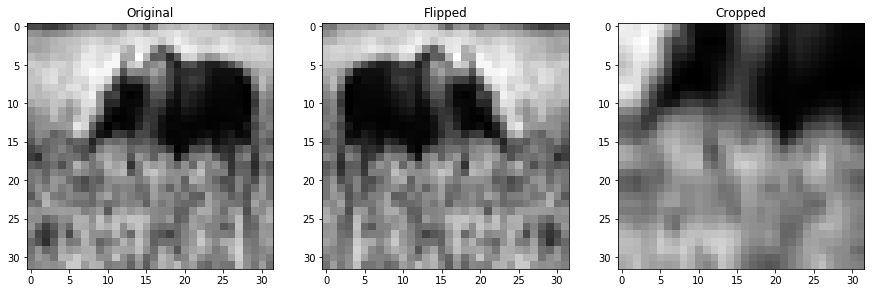

In [5]:
img1 = X_train[3].copy()
rot1 = augment_rotation(img1.reshape(1,3,32,32))[0,...]
cr1 = augment_crop(img1, size=20)

fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].imshow(img1[0,...], cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(rot1[0,...], cmap='gray')
ax[1].set_title('Flipped')
ax[2].imshow(cr1[0,...], cmap='gray')
ax[2].set_title('Cropped');

In [6]:
X_train_aug, y_train_aug = augment_dataset(X_train, y_train, n=1)

Rotation done


A Jupyter Widget

 - ##### CIFAR10:

In [7]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        #print(input.size())
        return input.view(input.size(0), -1)

In [8]:
model = nn.Sequential()
model.add_module('Conv1', nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1))
model.add_module('Conv1-2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1))
model.add_module('bn1', nn.BatchNorm2d(256))
model.add_module('relu1', nn.LeakyReLU())
model.add_module('mp1', nn.MaxPool2d(kernel_size=2))

model.add_module('Conv2', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
model.add_module('bn2', nn.BatchNorm2d(512))
model.add_module('relu2', nn.LeakyReLU())
model.add_module('mp2', nn.MaxPool2d(kernel_size=2))

model.add_module('Conv3', nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1))
model.add_module('bn3', nn.BatchNorm2d(1024))
model.add_module('relu3', nn.LeakyReLU())

model.add_module('av1', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', Flatten())
model.add_module('fc1', nn.LeakyReLU())

model.add_module('Lin', nn.Linear(1024, 10))
model.add_module('SM', nn.Softmax(dim=1))

model.cuda();

In [9]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch).cuda())
    y_batch = Variable(torch.LongTensor(y_batch).cuda())
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

__ Training __

In [10]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]
        
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
val_accuracy = []

In [11]:
import time
num_epochs = 25 # total amount of full passes over training data
batch_size = 128  # number of samples processed in one SGD iteration

for epoch in tqdm_notebook(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train_aug, y_train_aug, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
        
    if (epoch+1)%7==0 and (epoch+1)<=18:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/2
    elif (epoch+1)%3==0 and (epoch+1)>18:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/10
    
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

A Jupyter Widget

Epoch 1 of 25 took 329.111s
  training loss (in-iteration): 	2.001197
  validation accuracy: 			46.06 %
Epoch 2 of 25 took 323.498s
  training loss (in-iteration): 	1.880091
  validation accuracy: 			61.97 %
Epoch 3 of 25 took 323.449s
  training loss (in-iteration): 	1.823942
  validation accuracy: 			63.81 %
Epoch 4 of 25 took 323.420s
  training loss (in-iteration): 	1.783672
  validation accuracy: 			66.98 %
Epoch 5 of 25 took 323.510s
  training loss (in-iteration): 	1.744280
  validation accuracy: 			67.31 %
Epoch 6 of 25 took 323.389s
  training loss (in-iteration): 	1.723009
  validation accuracy: 			67.71 %
Epoch 7 of 25 took 323.443s
  training loss (in-iteration): 	1.695531
  validation accuracy: 			73.34 %
Epoch 8 of 25 took 323.418s
  training loss (in-iteration): 	1.652580
  validation accuracy: 			81.06 %
Epoch 9 of 25 took 323.533s
  training loss (in-iteration): 	1.637576
  validation accuracy: 			81.15 %
Epoch 10 of 25 took 323.568s
  training loss (in-iteration): 	1.

In [12]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 100):
    logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		85.57 %
Achievement unlocked: 110lvl Warlock!


Let's also check what is accuracy on the train

In [38]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_train, y_train, 100):
    logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  Train accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  Train accuracy:		96.43 %
Double-check, than consider applying for NIPS'18. SRSly.


That beacause I test an accaracy on non augmented training set. 

Let's save weights to use it in our new model:

In [13]:
layers, weights, biases = ['Conv1','Conv1-2','bn1','Conv2','bn2','Conv3','bn3'], dict(), dict()

weights['Conv1'] = model.Conv1.weight
biases['Conv1'] = model.Conv1.bias

weights['Conv1-2'] = model.__dict__['_modules']['Conv1-2'].weight
biases['Conv1-2'] = model.__dict__['_modules']['Conv1-2'].bias

weights['bn1'] = model.bn1.weight
biases['bn1'] = model.bn1.bias

weights['Conv2'] = model.Conv2.weight
biases['Conv2'] = model.Conv2.bias

weights['bn2'] = model.bn2.weight
biases['bn2'] = model.bn2.bias

weights['Conv3'] = model.Conv3.weight
biases['Conv3'] = model.Conv3.bias

weights['bn3'] = model.bn3.weight
biases['bn3'] = model.bn3.bias

 - ##### CIFAR100:

 - Select two classes from CIFAR100:

In [14]:
y_train100[y_train100==13] = 0.
y_train100[y_train100==37] = 1.

y_test100[y_test100==13] = 0.
y_test100[y_test100==37] = 1.

y_val100[y_val100==13] = 0.
y_val100[y_val100==37] = 1.

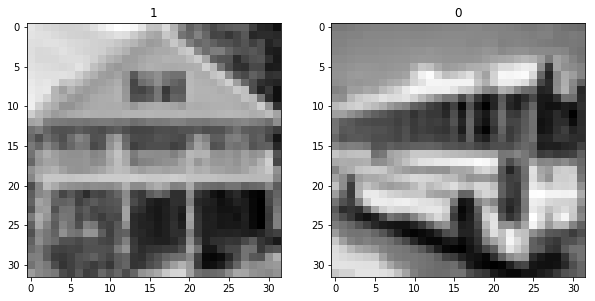

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(X_train100[0][0,...], cmap='gray')
ax[0].set_title(y_train100[0])
ax[1].imshow(X_train100[100][0,...], cmap='gray')
ax[1].set_title(y_train100[100]);

 - Redifine model with shared weights from previous task:

In [27]:
net = nn.Sequential()

net.add_module('Conv1', nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1)) #Conv1
net.Conv1.weight, net.Conv1.bias = weights['Conv1'], biases['Conv1']

net.add_module('Conv1-2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)) #Conv1-2
net.__dict__['_modules']['Conv1-2'].weight = weights['Conv1-2']
net.__dict__['_modules']['Conv1-2'].bias = biases['Conv1-2']

net.add_module('bn1', nn.BatchNorm2d(256)) #bn1
net.bn1.weight, net.bn1.bias = weights['bn1'], biases['bn1']

net.add_module('relu1', nn.LeakyReLU()) #ReLU1
net.add_module('mp1', nn.MaxPool2d(kernel_size=2)) #MP1

net.add_module('Conv2', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)) #Conv2
net.Conv2.weight, net.Conv2.bias = weights['Conv2'], biases['Conv2']

net.add_module('bn2', nn.BatchNorm2d(512)) #BN2
net.bn2.weight, net.bn2.bias = weights['bn2'], biases['bn2'] 

net.add_module('relu2', nn.LeakyReLU()) #ReLU2
net.add_module('mp2', nn.MaxPool2d(kernel_size=2)) #MP2

net.add_module('Conv3', nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)) #Conv3
net.Conv3.weight, net.Conv3.bias = weights['Conv3'], biases['Conv3'] 

net.add_module('bn3', nn.BatchNorm2d(1024)) #BN3
net.bn3.weight, net.bn3.bias = weights['bn3'], biases['bn3'] 

net.add_module('relu3', nn.LeakyReLU())

net.add_module('av1', nn.AvgPool2d(kernel_size=8)) #AV1
net.add_module('flatten', Flatten()) #Flatten
net.add_module('fc1', nn.LeakyReLU()) #fc1

net.add_module('Lin', nn.Linear(1024, 2)) #Linear
net.add_module('SM', nn.Softmax(dim=1)) #SM

net.cuda();

In [28]:
#Let's again augment a bit
X_train2_aug, y_train2_aug = augment_dataset(X_train100, y_train100, n=2)

Rotation done


A Jupyter Widget

In [29]:
opt = torch.optim.Adam([{'params': net.Conv1.parameters(), 'lr':1e-6},
                        {'params': net.__dict__['_modules']['Conv1-2'].parameters(), 'lr':1e-6},
                        {'params': net.bn1.parameters(), 'lr':1e-6},
                        {'params': net.relu1.parameters()},
                        {'params': net.mp1.parameters()},
                        {'params': net.Conv2.parameters(), 'lr':1e-6},
                        {'params': net.bn2.parameters(), 'lr':1e-6},
                        {'params': net.relu2.parameters()},
                        {'params': net.mp2.parameters()},
                        {'params': net.Conv3.parameters(), 'lr':1e-6},
                        {'params': net.bn3.parameters(), 'lr':1e-6},
                        {'params': net.relu3.parameters()},
                        {'params': net.av1.parameters()},
                        {'params': net.flatten.parameters()},
                        {'params': net.fc1.parameters()},
                        {'params': net.Lin.parameters()},
                        {'params': net.SM.parameters()}],
                        lr=1e-2)

train_loss = []
val_accuracy = []

In [30]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch).cuda())
    y_batch = Variable(torch.LongTensor(y_batch).cuda())
    logits = net(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

Fine-tune the model:

In [32]:
num_epochs = 15
batch_size = 64

for epoch in tqdm_notebook(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    net.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train2_aug, y_train2_aug, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
        
    if (epoch+1)%5==0 and (epoch+1)<=10:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/2
    elif (epoch+1)>10 and (epoch+1)%2 == 0:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/10
    
    # And a full pass over the validation data:
    net.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val100, y_val100, batch_size):
        logits = net(Variable(torch.FloatTensor(X_batch).cuda()))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

A Jupyter Widget

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/use/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/use/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/use/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Epoch 1 of 15 took 5.938s
  training loss (in-iteration): 	0.406519
  validation accuracy: 			95.51 %
Epoch 2 of 15 took 5.823s
  training loss (in-iteration): 	0.403737
  validation accuracy: 			95.53 %
Epoch 3 of 15 took 5.548s
  training loss (in-iteration): 	0.401626
  validation accuracy: 			95.48 %
Epoch 4 of 15 took 5.696s
  training loss (in-iteration): 	0.399845
  validation accuracy: 			95.10 %
Epoch 5 of 15 took 5.529s
  training loss (in-iteration): 	0.397727
  validation accuracy: 			95.12 %
Epoch 6 of 15 took 5.551s
  training loss (in-iteration): 	0.395864
  validation accuracy: 			94.90 %
Epoch 7 of 15 took 5.592s
  training loss (in-iteration): 	0.393932
  validation accuracy: 			94.87 %
Epoch 8 of 15 took 5.603s
  training loss (in-iteration): 	0.392854
  validation accuracy: 			94.92 %
Epoch 9 of 15 took 5.636s
  training loss (in-iteration): 	0.391769
  validation accuracy: 			95.01 %
Epoch 10 of 15 took 5.661s
  training loss (in-iteration): 	0.388929
  validation 

Test it:

In [33]:
net.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test100, y_test100, 100):
    logits = net(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		90.00 %
Achievement unlocked: 110lvl Warlock!


 - ##### Let's now use the same model with random initialization:

In [34]:
net = nn.Sequential()
net.add_module('Conv1', nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1))
net.add_module('Conv1-2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1))
net.add_module('bn1', nn.BatchNorm2d(256))
net.add_module('relu1', nn.LeakyReLU())
net.add_module('mp1', nn.MaxPool2d(kernel_size=2))

net.add_module('Conv2', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
net.add_module('bn2', nn.BatchNorm2d(512))
net.add_module('relu2', nn.LeakyReLU())
net.add_module('mp2', nn.MaxPool2d(kernel_size=2))

net.add_module('Conv3', nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1))
net.add_module('bn3', nn.BatchNorm2d(1024))
net.add_module('relu3', nn.LeakyReLU())

net.add_module('av1', nn.AvgPool2d(kernel_size=8))
net.add_module('flatten', Flatten())
net.add_module('fc1', nn.LeakyReLU())

net.add_module('Lin', nn.Linear(1024, 2))
net.add_module('SM', nn.Softmax(dim=1))

net.cuda()

Sequential(
  (Conv1): Conv2d (3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv1-2): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (relu1): LeakyReLU(0.01)
  (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (Conv2): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (relu2): LeakyReLU(0.01)
  (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (Conv3): Conv2d (512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (relu3): LeakyReLU(0.01)
  (av1): AvgPool2d(kernel_size=8, stride=8, padding=0, ceil_mode=False, count_include_pad=True)
  (flatten): Flatten(
  )
  (fc1): LeakyReLU(0.01)
  (Lin): Linear(in_features=1024, out_features=2)
  (SM): Softmax()
)

In [35]:
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

train_loss = []
val_accuracy = []

Train it:

In [36]:
num_epochs = 50
batch_size = 128

for epoch in tqdm_notebook(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    net.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train2_aug, y_train2_aug, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
        
    if (epoch+1)%5==0:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/2
    
    # And a full pass over the validation data:
    net.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val100, y_val100, batch_size):
        logits = net(Variable(torch.FloatTensor(X_batch).cuda()))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

A Jupyter Widget

Epoch 1 of 50 took 5.590s
  training loss (in-iteration): 	0.707205
  validation accuracy: 			50.91 %
Epoch 2 of 50 took 5.371s
  training loss (in-iteration): 	0.644073
  validation accuracy: 			60.18 %
Epoch 3 of 50 took 5.635s
  training loss (in-iteration): 	0.617619
  validation accuracy: 			62.82 %
Epoch 4 of 50 took 5.385s
  training loss (in-iteration): 	0.596741
  validation accuracy: 			67.51 %
Epoch 5 of 50 took 5.388s
  training loss (in-iteration): 	0.578547
  validation accuracy: 			67.49 %
Epoch 6 of 50 took 5.599s
  training loss (in-iteration): 	0.562597
  validation accuracy: 			69.79 %
Epoch 7 of 50 took 5.479s
  training loss (in-iteration): 	0.547628
  validation accuracy: 			70.85 %
Epoch 8 of 50 took 5.538s
  training loss (in-iteration): 	0.535693
  validation accuracy: 			72.09 %
Epoch 9 of 50 took 5.400s
  training loss (in-iteration): 	0.525641
  validation accuracy: 			73.05 %
Epoch 10 of 50 took 5.406s
  training loss (in-iteration): 	0.517306
  validation 

Test it:

In [37]:
net.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test100, y_test100, 100):
    logits = net(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		80.50 %
Achievement unlocked: 110lvl Warlock!


 - ##### Compare fine-tuned model and the one with a random initialization:

We observed that the model with random initialization can still achieve good accuracy (but probably because of just such dataset). However, it requires much more time to train in terms of numbers of epoches to converge to more or less good performance. While fine-tuning I didn't prevent the layers with learned weights from learning, but I specified a small learning rate for them. I found it's a good idea, because it slightly enhaced a performance and because of the tiny dataset, it's not so expensive. All in all, fine-tuned model needs much less time to train and accuracy is better for almost 10%.

# Report.

### Hi, my name is `Artem Moskalev`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, I got an idea:

* the idea

The main idea was to adopt some principles of AlexNet/VGG/InceptionNet in more simple and shallow network. My choice of architecture is not so sophisticated I guess, but it works well and I did some tricks to make it better.

* brief history of tweaks and improvements;

Firstly, I had just one 5x5 Convolution in the beginning. I still believe that it would work okay, but because of computational reasons, I substituted this layer with two consecutive 3x3 convolution. This trick actually was introduced in a paper about VGG and it's quite intuitive because the receptive field remains the same, but a number of parameters is lower. 

Second, inspired by augmentation techniques presented in AlexNet paper, I did flips and random crops and finally increased the size of my training data on CIFAR10 in 3 times. I believe that augmentation played an important role and greatly enhanced performance.

Third, to reduce the number of parameters and inspired by GoogLeNet paper, I did not use two fully connected layers in the end, but substituted first fully connected layer with average pooling to shrink all feature maps to the vector $ X\in R^C$, where $C$ is the number of channels.

* what is the final architecture and why?

These improvements led to the final choice of the architecture, which I used further. I also experimented with the different number of channels. The pipeline of $C^3 \rightarrow C^{256} \rightarrow C^{256} \rightarrow C^{512} \rightarrow C^{1024}$ seems to be the best for the specific architecture I use.

* what is the training method and, again, why?

Among optimization techniques I found an Adam (surprised?) to be the best. I also experimented with SGD. It's faster but earns poorer results (surprised?). 

To find an appropriate number of epochs I firstly ran a network through 50 epochs and found that after 18-th one there was absolutely no improvement on a validation set. I was able to fix it by decreasing learning rate and got the number of epochs that give an enhancement to 25. Experiments with decreasing learning rate after 25-th epoch with the total number of epochs increased were not so successful. 

The choice of a batch size was based on the idea to find a balance between computational time and the speed of convergence. With higher batch sizes network took larger steps to an optimum, but the price was the time. I found that the batch size of 128 is a good compromise.

* Any regularizations and other techniques applied and their effects;

I tried both Dropout and Batch Normalization. First did not give any improvements and even slightly reduced an accuracy. On the other hand, Batch Normalization greatly improved the performance and turned to be crucial to build a good network.
<br>
<br>
<br>
For fine-tuning and random-initialization on CIFAR's 100 two classes. The number of epochs was chosen based on the same principle: I first run a network on the many epochs and check after which one the performance plateaus, then play with decreasing learning rates to increase the number of epochs from which we the network is able to earn something.

P.S. Cool Homework. Thanks.